In [1]:
#Imports
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

## Data and dataloader preparation

In [48]:
data_path = untar_data(URLs.PETS)
print(data_path)

/home/jan/.fastai/data/oxford-iiit-pet


In [3]:
#Set the seed for reproducibility
np.random.seed(42)

In [49]:
#See the dataset structure
data_path.ls()[:3]

(#2) [Path('/home/jan/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/jan/.fastai/data/oxford-iiit-pet/images')]

Build `DataLoader` directly - highest level of FastAI API

In [44]:
filenames = get_image_files(data_path/ 'images')

In [47]:
L(data_path/'images')

(#1) [Path('/home/jan/.fastai/data/food-101/images')]

In [5]:
#Get the filenames and build the pattern to extract class from them
filenames = get_image_files(data_path/ 'images')
regx_pattern = r'(.+)_\d+.jpg$'

#Define some Image and Batch level transformations
item_tfms = RandomResizedCrop(460, min_scale =0.8, ratio = (1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
batch_size = 32 

#Build databunch
dataloader1 = ImageDataLoaders.from_name_re(data_path, filenames, regx_pattern, batch_tfms=batch_tfms, item_tfms = item_tfms, bs = batch_size)

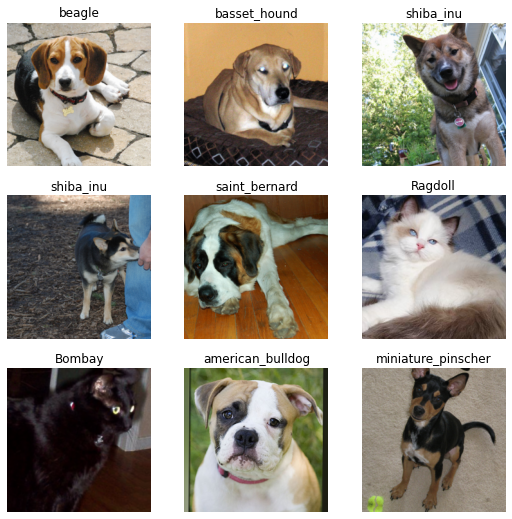

In [6]:
dataloader1.show_batch()

Alternatively, build `DataBlock` first (mid-level API) and then use it to generate `DataLoader`

In [7]:
# Define Datablock with (input,output) in blocks
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [8]:
image_path = data_path/'images'

In [9]:
#Build dataloaders
dataloaders2 = pets.dataloaders(image_path, bs=batch_size)

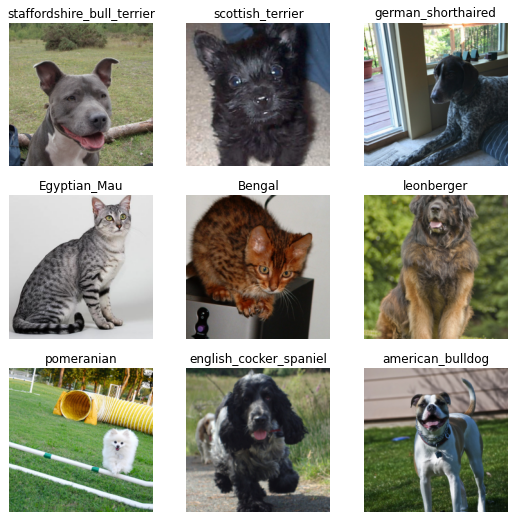

In [10]:
dataloaders2.show_batch()

One can also look at all the classes and their corresponding labels

In [11]:
dataloaders2.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

## Easiest classifier training

Create the simplest Learner (model+ training pipeline):
* pass the `Dataloaders`
* choose the model architecture
* choose the metrics to see how well model is performing
* choose loss function (so that model knows how to improve, default ` CrossEntropyFlat` in that case)
* choose optimizer (to tell the model how to adjust itself at each step, default `Adam` here)

In [22]:
learner = cnn_learner(dataloaders2, resnet50, pretrained=True, metrics=error_rate).to_fp16()

And train:

In [23]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.814205,0.348960,0.107578,00:24
1,0.436145,0.271164,0.081867,00:24
2,0.304890,0.262916,0.081191,00:24
3,0.195200,0.220191,0.069012,00:24
4,0.137224,0.209158,0.065629,00:24


In [24]:
learner.save('base_pet_classifier')

Path('models/base_pet_classifier.pth')

## Interpreting results

Using the interpration module and making sure we have all the validation scores/data aligned

In [25]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()

len(dataloaders2.valid_ds)==len(losses)==len(idxs)

True

Plot where the model was most wrong

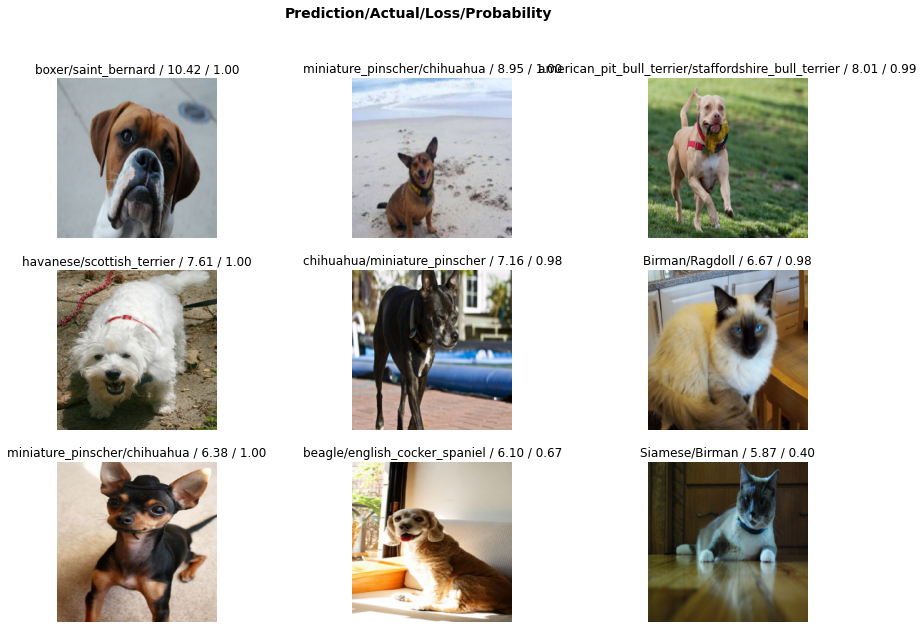

In [26]:
interp.plot_top_losses(9, figsize=(15,10))

Confusion Matrix will help too

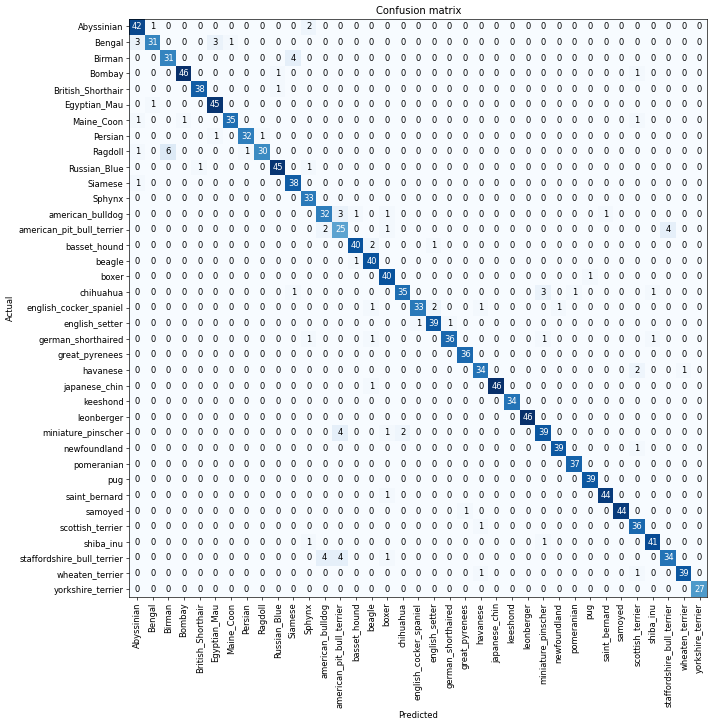

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Tuning the model a bit (prone to overfitting at the moment)

In [28]:
#Load the base model
learner.load('base_pet_classifier')

In [29]:
#Now the pretrained weights will change too, not only model head
learner.unfreeze()

In [30]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.251119,4.837820,0.796346,00:30
1,1.424189,1.237441,0.382273,00:30
2,0.777452,0.589305,0.192152,00:30
3,0.363433,0.474121,0.156292,00:31


It seems that the Learning Rate is too high when all model layers are unlocked and the gradients fly all over the place - model performance drops

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.2908675418875646e-06)

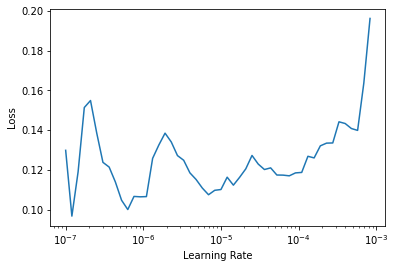

In [33]:
# Let's load it again, unfreeze and find a good learning rate
learner.load('base_pet_classifier')

learner.lr_find()

The LR between 1e-6 to 1e-4 seems good, we can actually set it as a slice so that deeper (earlier) layers in the model get adjusted less (they are already good at what they do)

In [34]:
learner.unfreeze()
learner.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.120696,0.221037,0.067659,00:31
1,0.109371,0.207672,0.066982,00:31
2,0.099056,0.212229,0.062246,00:30
3,0.068575,0.209082,0.061570,00:30


In [35]:
learner.save('tuned_pet_classifier')

Path('models/tuned_pet_classifier.pth')

Metrics have improved slightly, we can interpret it again. The easiest way to push the performance further would be to use larger model (ResNet50 for example).

In [36]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()

len(dataloaders2.valid_ds)==len(losses)==len(idxs)

True

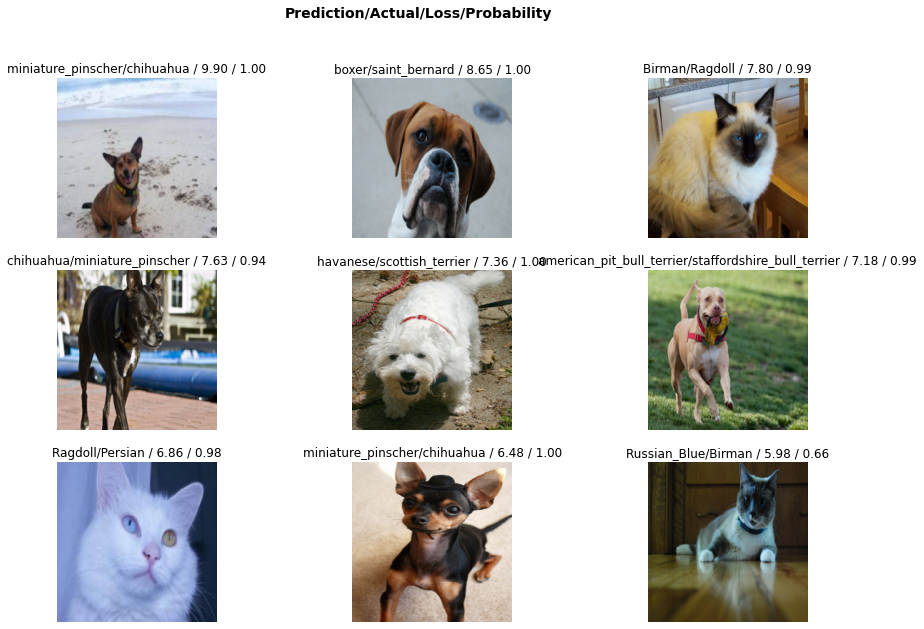

In [37]:
interp.plot_top_losses(9, figsize=(15,10))

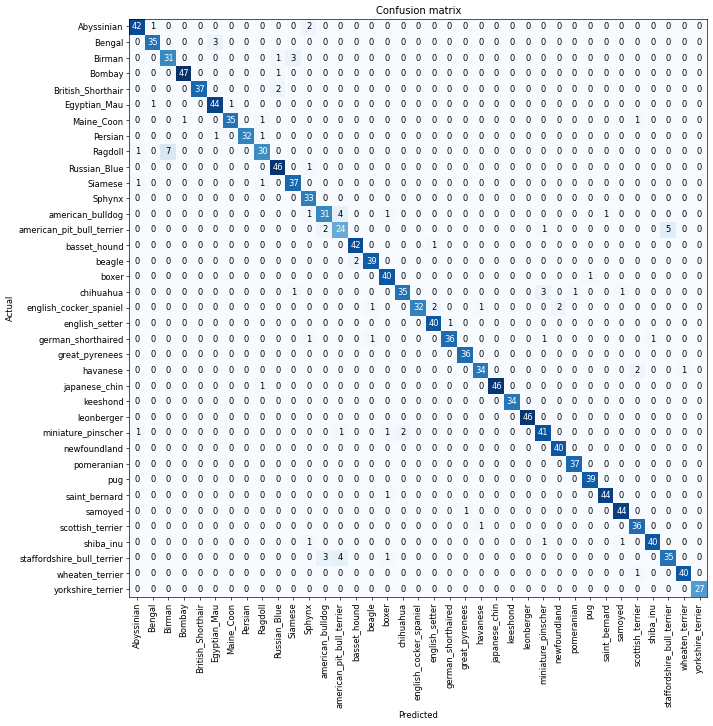

In [38]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Even the tuned model, still fails on the same images. Larger model might help, but cleaning/enlarging the dataset a bit would probably help too. It is also worth noting that despite overall decrease of error rate, in some specific cases error is larger now (Ragdoll/Birman case)

# Different dataset - FOOD

Not all datasets are organized in the same way, but the `DataBlock` API is pretty elastic. Let's build a classifier for FOOD dataset, which contains images for 101 different dishes

In [50]:
data_path2 = untar_data(URLs.FOOD)
print(data_path2)

/home/jan/.fastai/data/food-101


Let's look how the dataset is organized:

In [54]:
L(get_files(data_path2, recurse=False))

(#6) [Path('/home/jan/.fastai/data/food-101/test.txt'),Path('/home/jan/.fastai/data/food-101/train.txt'),Path('/home/jan/.fastai/data/food-101/classes.txt'),Path('/home/jan/.fastai/data/food-101/test.json'),Path('/home/jan/.fastai/data/food-101/train.json'),Path('/home/jan/.fastai/data/food-101/labels.txt')]

In [58]:
L(get_files(data_path2/'images'))

(#101000) [Path('/home/jan/.fastai/data/food-101/images/lasagna/555862.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/3874120.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/3476066.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/2923855.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/2055421.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/3717740.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/1675979.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/3619303.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/1321748.jpg'),Path('/home/jan/.fastai/data/food-101/images/lasagna/2048823.jpg')...]

It seems that:
* Instead of all images being in images folder directly, they are in subfolders (according to class)
* Therefore, class names need to be taken from those folders, not the filenames
* There is already train/test split with list of files beloning to each fold in txt/json files

We can approach that in 2 ways:
1. Use the pre-defined train set as train+val and keep the test set separate for model evaluation (proper approach)
2. Use pre-defined train set as training set and pre-defined test as validation set (just for training purposes)

I'll build DataBlocks for both approaches

In [76]:
#Load the paths and add extensions
with open(str(data_path2/'train.txt'),'r') as f:
    train_paths = f.read().split('\n')[:-1]
    
with open(str(data_path2/'test.txt'),'r') as f:
    test_paths = f.read().split('\n')[:-1]
    
train_paths =[p+'.jpg' for p in train_paths]
test_paths =[p+'.jpg' for p in test_paths]

In [88]:
#Let's create a dictionary of nice labels for the classes too

with open(str(data_path2/'labels.txt'),'r') as f:
    labels = f.read().split('\n')[:-1]
with open(str(data_path2/'classes.txt'),'r') as f:
    classes = f.read().split('\n')[:-1]

labels_dict = {k:v for k,v in zip(classes,labels) }
print(len(classes), len(labels))

101 101


In [87]:
labels_dict

{'apple_pie': 'Apple pie',
 'baby_back_ribs': 'Baby back ribs',
 'baklava': 'Baklava',
 'beef_carpaccio': 'Beef carpaccio',
 'beef_tartare': 'Beef tartare',
 'beet_salad': 'Beet salad',
 'beignets': 'Beignets',
 'bibimbap': 'Bibimbap',
 'bread_pudding': 'Bread pudding',
 'breakfast_burrito': 'Breakfast burrito',
 'bruschetta': 'Bruschetta',
 'caesar_salad': 'Caesar salad',
 'cannoli': 'Cannoli',
 'caprese_salad': 'Caprese salad',
 'carrot_cake': 'Carrot cake',
 'ceviche': 'Ceviche',
 'cheesecake': 'Cheesecake',
 'cheese_plate': 'Cheese plate',
 'chicken_curry': 'Chicken curry',
 'chicken_quesadilla': 'Chicken quesadilla',
 'chicken_wings': 'Chicken wings',
 'chocolate_cake': 'Chocolate cake',
 'chocolate_mousse': 'Chocolate mousse',
 'churros': 'Churros',
 'clam_chowder': 'Clam chowder',
 'club_sandwich': 'Club sandwich',
 'crab_cakes': 'Crab cakes',
 'creme_brulee': 'Creme brulee',
 'croque_madame': 'Croque madame',
 'cup_cakes': 'Cup cakes',
 'deviled_eggs': 'Deviled eggs',
 'donuts'

In [80]:
len(train_paths),len(test_paths)

101


(75750, 25250, None)

In [89]:
from collections import Counter

In [91]:
train_labels = [f.split('/')[0] for f in train_paths]
Counter(train_labels)

Counter({'apple_pie': 750,
         'baby_back_ribs': 750,
         'baklava': 750,
         'beef_carpaccio': 750,
         'beef_tartare': 750,
         'beet_salad': 750,
         'beignets': 750,
         'bibimbap': 750,
         'bread_pudding': 750,
         'breakfast_burrito': 750,
         'bruschetta': 750,
         'caesar_salad': 750,
         'cannoli': 750,
         'caprese_salad': 750,
         'carrot_cake': 750,
         'ceviche': 750,
         'cheesecake': 750,
         'cheese_plate': 750,
         'chicken_curry': 750,
         'chicken_quesadilla': 750,
         'chicken_wings': 750,
         'chocolate_cake': 750,
         'chocolate_mousse': 750,
         'churros': 750,
         'clam_chowder': 750,
         'club_sandwich': 750,
         'crab_cakes': 750,
         'creme_brulee': 750,
         'croque_madame': 750,
         'cup_cakes': 750,
         'deviled_eggs': 750,
         'donuts': 750,
         'dumplings': 750,
         'edamame': 750,
         '

One can see that there are 101 classes, with 1000 images for each class split into 75% train and 25% test set.
Let's prepare the Datablocks

## 1. Using the pre-defined train for train+val

Here, `Randomsplitter()` is still needed to spit into train/val subsets. However `get_items` and `get_y` functions wil be different. Item/batch transformations can be left the same

In [106]:
def get_files1(path):
    with open(str(data_path2/'train.txt'),'r') as f:
        train_paths = f.read().split('\n')[:-1]
    return L([path /'images'/ (p+'.jpg') for p in train_paths])

In [107]:
def get_label(f):
    return labels_dict[str(f).split('/')[-2]]

In [130]:
foods1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_files1,
                 splitter=RandomSplitter(valid_pct=0.25),
                 get_y=get_label,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [131]:
dataloaders3 = foods1.dataloaders(data_path2, bs=batch_size)

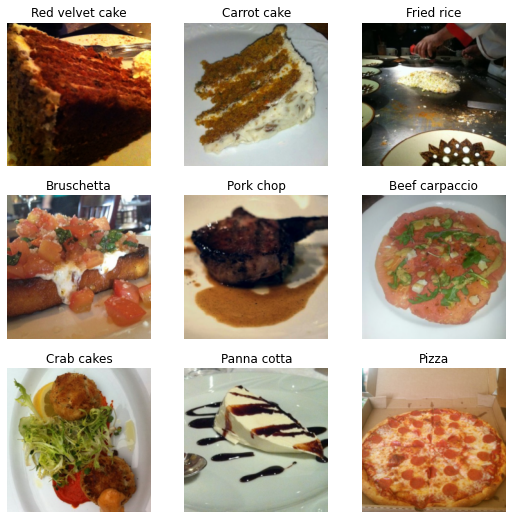

In [132]:
dataloaders3.show_batch()

## 2. Using pre-defined train for train, and pre-defined test for val

Now we can use same `get_image_files` as earlier (since we'll use all the images), we can reuse `get_label` from above as well. However, new splitter will be needed based on the information in the txts

In [138]:
with open(str(data_path2/'test.txt'),'r') as f:
    test_paths = f.read().split('\n')[:-1]
test_paths =  L([data_path2 /'images'/ (p+'.jpg') for p in test_paths])
 

In [139]:
def is_in_test(f):
    return f in test_paths

In [140]:
foods2 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=FuncSplitter(is_in_test),
                 get_y=get_label,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [141]:
#WARNING - SUPER SLOW
dataloaders4 = foods2.dataloaders(data_path2, bs=batch_size)

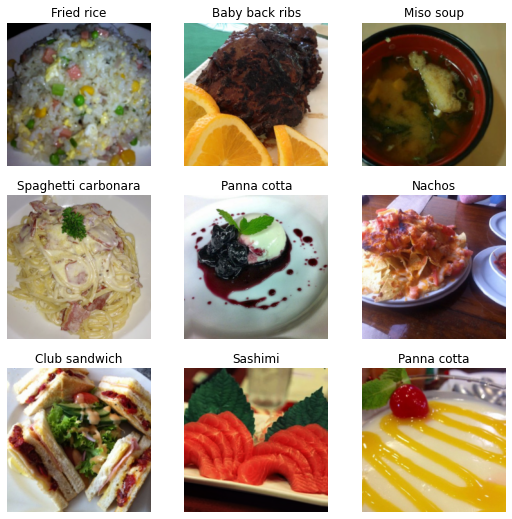

In [142]:
dataloaders4.show_batch()

That worked, but it was super slow, since every single item was checked against the test list. Let's see if it can be sped up using Pandas

In [145]:
#I already have test_paths, let's get train_paths now too
with open(str(data_path2/'train.txt'),'r') as f:
    train_paths = f.read().split('\n')[:-1]
train_paths =  L([data_path2 /'images'/ (p+'.jpg') for p in train_paths])

In [148]:
#Let's turn both these lists of paths into nice dictionaries
train_dicts = [{'fname':f, 'label': get_label(f), 'is_valid':False} for f in train_paths]
test_dicts = [{'fname':f, 'label': get_label(f), 'is_valid':True} for f in test_paths]

In [150]:
import pandas as pd

In [151]:
#Create DataFrame
df = pd.DataFrame.from_dict(train_dicts+test_dicts)
df.head(10)

I need separate `get_x` and `get_y` functions now to get filenames and labels respectively for each row in the DataFrame. I also use the `ColSplitter` function to split into train/val based on the `is_valid` column 

In [154]:
foods3 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_x=ColReader('fname'),
                 splitter=ColSplitter('is_valid'),
                 get_y=ColReader('label'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [155]:
dataloaders5 = foods3.dataloaders(df, bs=batch_size)

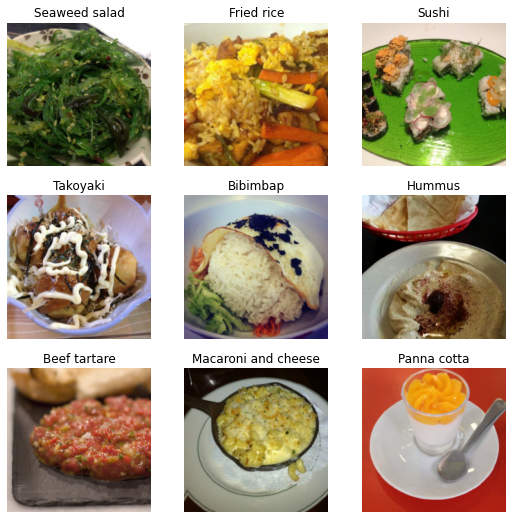

In [156]:
dataloaders5.show_batch()

This was much faster, yielding the same result. One can verify that dataloader3 is smaller (as expected), while 4 and 5 have the same size (split done properly)

In [157]:
len(dataloaders3.train),len(dataloaders4.train),len(dataloaders5.train)

(1775, 2367, 2367)